In [1]:
import torch
from typing import Optional, Dict
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from IPython.display import clear_output

import gymnasium as gym
import torch
import numpy as np

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure

@dataclass
class SimulationConfig:
    n_markers: int = 1000
    pop_size: int = 1000
    h2: float = 1.0
    sparse_reward: bool = True

class Genome:
    def __init__(self, n_markers: int):
        self.ploidy: int = 2
        self.n_markers: int = n_markers

    def __repr__(self) -> str:
        return f"Genome(ploidy={self.ploidy}, n_markers={self.n_markers})"

class Population:
    def __init__(self, pop_size: int, starting_parents:int, genome: Genome, device: torch.device):
        self.pop_size: int = pop_size
        self.genome: Genome = genome
        self.device: torch.device = device
        # self.haplotypes: torch.Tensor = torch.randint(0, 2, (pop_size, genome.ploidy, genome.n_markers),
        #                                               dtype=torch.float32, device=self.device)
        
        inbred_data = np.load('g2f_ch10.npy', allow_pickle=True)
        
        if starting_parents > inbred_data.shape[0]:
            raise ValueError("Total parents requested exceed the number of available parents.")
        if genome.n_markers > inbred_data.shape[2]:
            raise ValueError("Total markers requested exceed the number of available markers.")
        # Randomly sample parents
        sampled_parents_indices = np.random.choice(inbred_data.shape[0], starting_parents, replace=False)
        sampled_parents = inbred_data[sampled_parents_indices, :, :]
        # Randomly sample markers
        sampled_markers_indices = np.random.choice(inbred_data.shape[2], genome.n_markers, replace=False)
        self.haplotypes =  torch.tensor(sampled_parents[:, :, sampled_markers_indices], device=self.device).float()

        f1_gametes = SimOps.meiosis(self.haplotypes, num_crossovers=3)
        self.haplotypes = SimOps.random_cross(f1_gametes, total_crosses=pop_size)

        f2_seg_gametes = SimOps.meiosis(self.haplotypes, num_crossovers=3)
        self.haplotypes = SimOps.random_cross(f2_seg_gametes, total_crosses=pop_size)


    def to(self, device: torch.device) -> 'Population':
        self.device = device
        self.haplotypes = self.haplotypes.to(device)
        return self

    def __repr__(self) -> str:
        return f"Population(pop_size={self.pop_size}, genome={self.genome}, device={self.device})"


class Trait:
    def __init__(self, genome: Genome, population: Population, target_mean: float = 0.0, target_variance: float = 1.0):
        self.genome: Genome = genome
        self.device: torch.device = population.device
        self.target_mean: float = target_mean
        self.target_variance: float = target_variance

        raw_effects = torch.randn(genome.n_markers, device=self.device)
        centered_effects = raw_effects - raw_effects.mean()

        dosages = population.haplotypes.sum(dim=1)
        founder_values = torch.einsum('ij,j->i', dosages, centered_effects)
        founder_mean = founder_values.mean()
        founder_var = founder_values.var()

        scaling_factor = torch.sqrt(self.target_variance / founder_var)
        self.effects: torch.Tensor = centered_effects * scaling_factor
        self.intercept: torch.Tensor = (torch.tensor(self.target_mean, device=self.device) - founder_mean).detach()

    def to(self, device: torch.device) -> 'Trait':
        self.device = device
        self.effects = self.effects.to(device)
        self.intercept = self.intercept.to(device)
        return self

    def __repr__(self) -> str:
        return f"Trait(target_mean={self.target_mean}, target_variance={self.target_variance}, device={self.device})"

class SimOps:
    @staticmethod
    def score_population(population: Population, trait: Trait, h2: float = 1.0) -> torch.Tensor:
        dosages = population.haplotypes.sum(dim=1)
        breeding_values = torch.einsum('ij,j->i', dosages, trait.effects) + trait.intercept

        bv_var = breeding_values.var()
        if bv_var == 0 or h2 >= 1:
            return breeding_values

        env_variance = (1 - h2) / h2 * bv_var.item()
        env_std = torch.sqrt(torch.tensor(env_variance, device=population.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        return breeding_values + env_effects


    @staticmethod
    def truncation_selection(population: Population, phenotypes: torch.Tensor, selection_intensity: float) -> torch.Tensor:
        assert 0 < selection_intensity <= 1, "Selection intensity must be between 0 and 1"
        assert population.haplotypes.shape[0] == phenotypes.shape[0], "Mismatch between population size and phenotypes"

        num_select = max(1, min(int(selection_intensity * population.pop_size), population.pop_size - 1))
        _, top_indices = torch.topk(phenotypes, num_select)
        return population.haplotypes[top_indices]


    @staticmethod
    def meiosis(selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        num_parents, ploidy, num_markers = selected_haplotypes.shape

        # Repeat each parent's haplotypes num_gametes_per_parent times
        expanded_haplotypes = selected_haplotypes.repeat_interleave(num_gametes_per_parent, dim=0)

        # The rest of the function remains largely the same, but operates on the expanded haplotypes
        total_gametes = num_parents * num_gametes_per_parent

        crossover_points = torch.randint(1, num_markers, (total_gametes, num_crossovers), device=selected_haplotypes.device)
        crossover_points, _ = torch.sort(crossover_points, dim=1)

        crossover_mask = torch.zeros((total_gametes, num_markers), dtype=torch.bool, device=selected_haplotypes.device)
        crossover_mask.scatter_(1, crossover_points, 1)
        crossover_mask = torch.cumsum(crossover_mask, dim=1) % 2 == 1

        crossover_mask = crossover_mask.unsqueeze(1).expand(-1, ploidy, -1)

        start_chromosome = torch.randint(0, ploidy, (total_gametes, 1), device=selected_haplotypes.device)
        start_mask = start_chromosome.unsqueeze(-1).expand(-1, -1, num_markers)

        final_mask = crossover_mask ^ start_mask.bool()

        offspring_haplotypes = torch.where(final_mask, expanded_haplotypes, expanded_haplotypes.roll(shifts=1, dims=1))

        # Return only the first haplotype for each meiosis event
        return offspring_haplotypes[:, 0, :]
    @staticmethod
    def check_cuda(tensor: torch.Tensor, name: str) -> None:
        print(f"{name} is on: {tensor.device}")


    @staticmethod
    def random_cross(gamete_tensor: torch.Tensor, total_crosses: int) -> torch.Tensor:
        num_gametes, n_markers = gamete_tensor.shape

        # Assert that total_crosses is less than half the number of gametes
        assert total_crosses <= num_gametes // 2, f"Total crosses ({total_crosses}) must be less than or equal to half the number of gametes ({num_gametes // 2})"

        # Randomly select gametes for crossing
        gamete_indices = torch.randperm(num_gametes, device=gamete_tensor.device)
        parent1_indices = gamete_indices[:total_crosses]
        parent2_indices = gamete_indices[total_crosses:2*total_crosses]

        # Create the new population haplotype tensor
        new_population = torch.stack([
            gamete_tensor[parent1_indices],
            gamete_tensor[parent2_indices]
        ], dim=1)

        return new_population

##################

class SimParams:
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.genome = Genome(config.n_markers)
        self.population = Population(config.pop_size, self.genome, self.device)
        self.trait = Trait(self.genome, self.population)


    def score_population(self, h2: Optional[float] = None) -> torch.Tensor:
        h2 = h2 if h2 is not None else self.config.h2
        return SimOps.score_population(self.population, self.trait, h2)

    def truncation_selection(self, selection_intensity: Optional[float] = None, phenotypes: Optional[torch.Tensor] = None) -> torch.Tensor:
        selection_intensity = selection_intensity if selection_intensity is not None else self.config.selection_intensity
        if phenotypes is None:
            phenotypes = self.score_population()
        return SimOps.truncation_selection(self.population, phenotypes, selection_intensity)

    def check_device(self) -> None:
        SimOps.check_cuda(self.population.haplotypes, "Population haplotypes")
        SimOps.check_cuda(self.trait.effects, "Trait effects")
        SimOps.check_cuda(self.trait.intercept, "Trait intercept")

    def to(self, device: torch.device) -> 'SimParams':
        self.device = device
        self.population = self.population.to(device)
        self.trait = self.trait.to(device)
        return self
    
    def perform_meiosis(self, selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        return SimOps.meiosis(selected_haplotypes, num_crossovers, num_gametes_per_parent)

    def create_next_generation(self, gametes: torch.Tensor, total_crosses: int) -> None:
        new_population_haplotypes = SimOps.random_cross(gametes, total_crosses)
#         assert new_population_haplotypes.shape[0] == self.config.pop_size, "Population size changed unexpectedly"
        self.population.haplotypes = new_population_haplotypes
        self.population.pop_size = total_crosses


class SelectionIntensityEnvironment(gym.Env):
    def __init__(self, SP, config, max_generations=10):
        super(SelectionIntensityEnvironment, self).__init__()
        self.SP = SP
        self.config = config
        self.max_generations = max_generations
        self.current_generation = 0
        self.founder_population = self.SP.population.haplotypes

        self.action_space = gym.spaces.Box(low=0.01, high=0.99, shape=(1,), dtype=np.float32)

        self.observation_space = gym.spaces.Dict({
            "generation_percent_remaining": gym.spaces.Box(low=0, high=max_generations, shape=(1,), dtype=np.float32),
            "genetic_var": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
        })

        self.current_population = self.SP.population.haplotypes.clone()
        self.phenotypes = self.SP.score_population()


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.SP.population.haplotypes = self.founder_population.clone()
        self.phenotypes = self.SP.score_population()
        return self._get_observation(), {}

    def _get_observation(self):
        return {
            "generation_percent_remaining": (self.max_generations - self.current_generation) / self.max_generations,
            "genetic_var": self.phenotypes.var().item()
        }

    def render(self):
        print(f"Generation: {self.current_generation}/{self.max_generations}")
        print(f"Best Phenotype: {self.phenotypes.max().item():.4f}")
        print(f"Average Phenotype: {self.phenotypes.mean().item():.4f}")
        print(f"Genetic Variance: {self.phenotypes.var().item():.4f}")
        print(f"Last Selection Intensity: {self.last_selection_intensity:.2f}")
        print("-" * 40)

    def step(self, action):
        selection_intensity = action

        selected_haplotypes = self.SP.truncation_selection(selection_intensity, self.phenotypes)
        total_crosses = self.config.pop_size
        total_gametes_needed = total_crosses * 2  # Each offspring needs 2 gametes
        num_parents = selected_haplotypes.shape[0]

        # Calculate gametes per parent, rounding up to ensure we have enough
        num_gametes_per_parent = -(-total_gametes_needed // num_parents)  # Ceiling division

        # Add a small buffer to ensure we have more than enough gametes
        num_gametes_per_parent += 2
        gametes = self.SP.perform_meiosis(selected_haplotypes, num_crossovers=3, num_gametes_per_parent=num_gametes_per_parent)
        self.SP.create_next_generation(gametes, total_crosses)
        self.phenotypes = self.SP.score_population()
        
        self.current_generation += 1
        done = self.current_generation >= self.max_generations
        # Implement sparse reward
        if self.config.sparse_reward:
            if done:
                # Only give reward at the end of the episode
                reward = float(self.phenotypes.max().item())
            else:
                reward = 0.0
        else:
            # Dense reward (existing implementation)
            reward = float(self.phenotypes.max().item())
        observation = self._get_observation()

        info = {
            'max_phenotype': float(self.phenotypes.max().item()),
            'genetic_variance': float(self.phenotypes.var().item()),
            'selection_intensity': float(action),
            'current_generation': self.current_generation
        }

        return observation, reward, done, False, info



### USAGE

from stable_baselines3 import PPO  # or any other RL algorithm you're using

config = SimulationConfig(n_markers=100, pop_size=50, h2=1)
SP = SimParams(config)
env = SelectionIntensityEnvironment(SP, config, max_generations=5)

print('train')
model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log="./ppotb/")

train
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [2]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=100, plot_interval=1000, window_size=100):
        super().__init__(verbose)
        self.log_interval = log_interval
        self.plot_interval = plot_interval
        self.window_size = window_size
        self.step_counter = 0
        self.generation_data = {}
        self.moving_avg_data = {}
        self.timesteps_history = []
        self.writer = None

    def _on_training_start(self):
        self.writer = SummaryWriter(self.logger.dir)

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        current_generation = info['current_generation']
        
        if current_generation not in self.generation_data:
            self.generation_data[current_generation] = {
                'max_phenotypes': [],
                'genetic_variances': [],
                'si': [],
                'timesteps': []
            }
            self.moving_avg_data[current_generation] = {
                'max_phenotypes': [],
                'genetic_variances': [],
                'si': [],
                'timesteps': []
            }
        
        self.generation_data[current_generation]['max_phenotypes'].append(info['max_phenotype'])
        self.generation_data[current_generation]['genetic_variances'].append(info['genetic_variance'])
        self.generation_data[current_generation]['si'].append(info['selection_intensity'])
        self.generation_data[current_generation]['timesteps'].append(self.num_timesteps)
        
        self.step_counter += 1
        
        if self.step_counter % self.log_interval == 0:
            self._update_moving_averages()

        if self.step_counter % self.plot_interval == 0:
            self._log_to_tensorboard()
            
        if self.step_counter % self.plot_interval == 0:
            self._plot_data()

        return True

    def _update_moving_averages(self):
        for gen in self.generation_data:
            data = self.generation_data[gen]
            if len(data['max_phenotypes']) >= self.window_size:
                avg_phenotype = np.mean(data['max_phenotypes'][-self.window_size:])
                avg_variance = np.mean(data['genetic_variances'][-self.window_size:])
                avg_si = np.mean(data['si'][-self.window_size:])
                avg_timestep = data['timesteps'][-1]
                
                self.moving_avg_data[gen]['max_phenotypes'].append(avg_phenotype)
                self.moving_avg_data[gen]['genetic_variances'].append(avg_variance)
                self.moving_avg_data[gen]['si'].append(avg_si)
                self.moving_avg_data[gen]['timesteps'].append(avg_timestep)

    def _plot_data(self):
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            plt.plot(data['timesteps'], data['max_phenotypes'], label=f'Gen {gen}')
        
        plt.xlabel('Timesteps')
        plt.ylabel('Max Phenotype (Moving Average)')
        plt.title('Max Phenotype by Generation')
        plt.legend()
        plt.grid(True)
        plt.show()

    def on_training_end(self):
        self._plot_data()  # Final plot at the end of training
        
    def _log_to_tensorboard(self):
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            for i, (timestep, max_phenotype, genetic_variance, avg_si) in enumerate(zip(data['timesteps'], data['max_phenotypes'], data['genetic_variances'], data['si'])):
                self.writer.add_scalar(f'Max_Phenotype/Gen_{gen}', max_phenotype, timestep)
                self.writer.add_scalar(f'Genetic_Variance/Gen_{gen}', genetic_variance, timestep)
                self.writer.add_scalar(f'action/Gen_{gen}', avg_si, timestep)

    def on_training_end(self):
        self._log_to_tensorboard()
        if self.writer:
            self.writer.close()
            
def collect_baselines(env, num_episodes=10, selection_intensities=[0.01, 0.02, 0.03, 0.04, 0.05], num_reps=5):
    baselines = {}
    for intensity in selection_intensities:
        all_rewards = []
        for _ in range(num_reps):
            rewards = []
            for _ in range(num_episodes):
                obs, _ = env.reset()
                done = False
                episode_reward = 0
                while not done:
                    action = np.array([intensity])
                    obs, reward, done, _, _ = env.step(action)
                    episode_reward += reward
                rewards.append(episode_reward)
            all_rewards.extend(rewards)
        baselines[intensity] = all_rewards
    return baselines

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_baselines(baselines):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=[[r for r in baselines[i]] for i in baselines.keys()])
    plt.xlabel('Selection Intensity')
    plt.ylabel('Total Reward')
    plt.title('Baseline Performance for Different Selection Intensities')
    plt.xticks(range(len(baselines)), list(baselines.keys()))
    plt.show()
    

/tmp/ipykernel_12946/1359994727.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_select = max(1, min(int(selection_intensity * population.pop_size), population.pop_size - 1))
/tmp/ipykernel_12946/1359994727.py:270: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'selection_intensity': float(action),


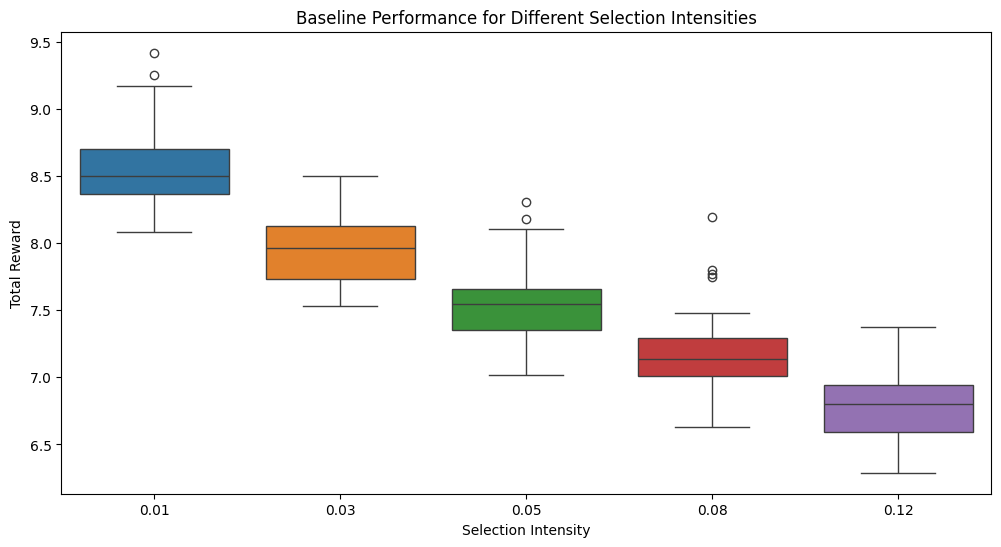

Selection Intensity 0.01:
  Mean Reward: 8.55
  Std Dev Reward: 0.30
  Max Reward: 9.42
  Min Reward: 8.08

Selection Intensity 0.03:
  Mean Reward: 7.96
  Std Dev Reward: 0.25
  Max Reward: 8.50
  Min Reward: 7.53

Selection Intensity 0.05:
  Mean Reward: 7.55
  Std Dev Reward: 0.24
  Max Reward: 8.30
  Min Reward: 7.02

Selection Intensity 0.08:
  Mean Reward: 7.18
  Std Dev Reward: 0.29
  Max Reward: 8.19
  Min Reward: 6.63

Selection Intensity 0.12:
  Mean Reward: 6.77
  Std Dev Reward: 0.24
  Max Reward: 7.37
  Min Reward: 6.29



In [3]:
total_timesteps=100000
max_generations = 3
# Assuming you have already defined your environment
config = SimulationConfig(n_markers=200, pop_size=1000, h2=1.0)
SP = SimParams(config)
env = SelectionIntensityEnvironment(SP, config, max_generations=max_generations)





# Collect baselines with repetitions
num_episodes = 10
selection_intensities = [0.01, 0.03, 0.05, 0.08, 0.12]
num_reps = 5  # Number of repetitions

baselines = collect_baselines(env, num_episodes, selection_intensities, num_reps)

# Visualize baselines
visualize_baselines(baselines)



# Print some statistics
for intensity, rewards in baselines.items():
    print(f"Selection Intensity {intensity}:")
    print(f"  Mean Reward: {np.mean(rewards):.2f}")
    print(f"  Std Dev Reward: {np.std(rewards):.2f}")
    print(f"  Max Reward: {np.max(rewards):.2f}")
    print(f"  Min Reward: {np.min(rewards):.2f}")
    print()


In [4]:
%%timeit
env.step(.5)

6.11 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit
env.reset()

189 µs ± 7.61 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


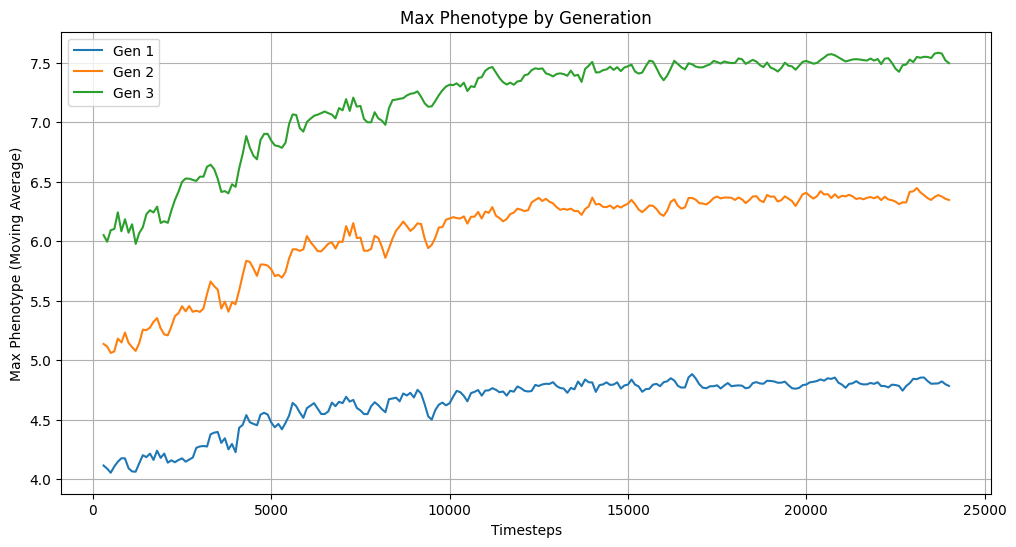

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3            |
|    ep_rew_mean          | 7.57         |
| time/                   |              |
|    fps                  | 153          |
|    iterations           | 12           |
|    time_elapsed         | 159          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0048465435 |
|    clip_fraction        | 0.0565       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.799       |
|    explained_variance   | 0.0493       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0675       |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00792     |
|    std                  | 0.531        |
|    value_loss           | 0.0837       |
------------------------------------------


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/glect/miniconda3/envs/breeding/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_9659/3543000260.py", line 13, in <module>
  File "/home/glect/miniconda3/envs/breeding/lib/python3.11/site-packages/stable_baselines3/ppo/ppo.py", line 315, in learn
    return super().learn(
           ^^^^^^^^^^^^^^
  File "/home/glect/miniconda3/envs/breeding/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py", line 300, in learn
    continue_training = self.collect_rollouts(self.env, callback, self.rollout_buffer, n_rollout_steps=self.n_steps)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/glect/miniconda3/envs/breeding/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py", line 20

PermissionError: [Errno 13] Permission denied: b'./ppo_tensorboard/PPO_17/events.out.tfevents.1721614911.glect.9659.3'

In [11]:
from stable_baselines3 import PPO



# Initialize your environment and model
# env = SelectionIntensityEnvironment(SP, config, max_generations=3)
model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log="./ppo_tensorboard/")

# Create the custom callback
custom_callback = CustomCallback()

# Train the model with the custom callback
model.learn(total_timesteps=total_timesteps, callback=custom_callback)